In [1]:
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [2]:
class HDF5PhotonTable(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PhotonTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.weights = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
            data_df = data_df.loc[data_df["weight"] > 0]


            if len(data_df) > 1000:
                data_df = data_df.sample(1000)



            data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())
            data = data_df.to_numpy()

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[:, 1] - 1), 16)

            labels = torch.empty((data.shape[0], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[:, 0]))
            self.weights.append(torch.DoubleTensor(data[:, 2]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.weights = torch.concat(self.weights)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.weights[key], self.labels[key]


    """
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding

            yield torch.DoubleTensor(data[0]).to(device), torch.DoubleTensor(data[2]).to(device), labels.to(device)
    """
        

In [3]:
def read_table_hdf(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
        data_df = data_df.loc[data_df["weight"] > 0]

        data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())

        
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

In [4]:
ds = HDF5PhotonTable("../assets/photon_table.hd5", 0, -1)

split_len = int(np.ceil(0.7*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=10000)


In [5]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)

for epoch in range(100):
    loss = 0
    for (times, weights, labels) in train_loader:
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)

        weights = weights / torch.sum(weights) * len(weights)

        if any(~torch.isfinite(weights)):
            raise RuntimeError

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf * weights).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

    loss /= len(train_loader)
    

    loss_test = 0
    for (times, weights, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        weights = weights / torch.sum(weights) * len(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf * weights).mean().detach()
    
    loss_test /= len(test_loader)

    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



Epoch: 0  Loss Train: 11.96306  Loss Test: 4.82265
Epoch: 1  Loss Train: 4.73508  Loss Test: 4.79391
Epoch: 2  Loss Train: 4.54719  Loss Test: 4.85325
Epoch: 3  Loss Train: 4.38391  Loss Test: 4.51845
Epoch: 4  Loss Train: 4.23813  Loss Test: 4.27911


In [67]:
ev = read_table_hdf("../assets/photon_table.hd5", 1100)
print(ev[1])

{'dir_phi': -2.1215658683419325, 'dir_theta': 1.0752405828287952, 'distance': 10.366329193115234, 'energy': 24582.440689201972, 'pos_phi': -2.447695988157297, 'pos_theta': 1.3868619709533536}


/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/chrhck/.local/lib/python3.

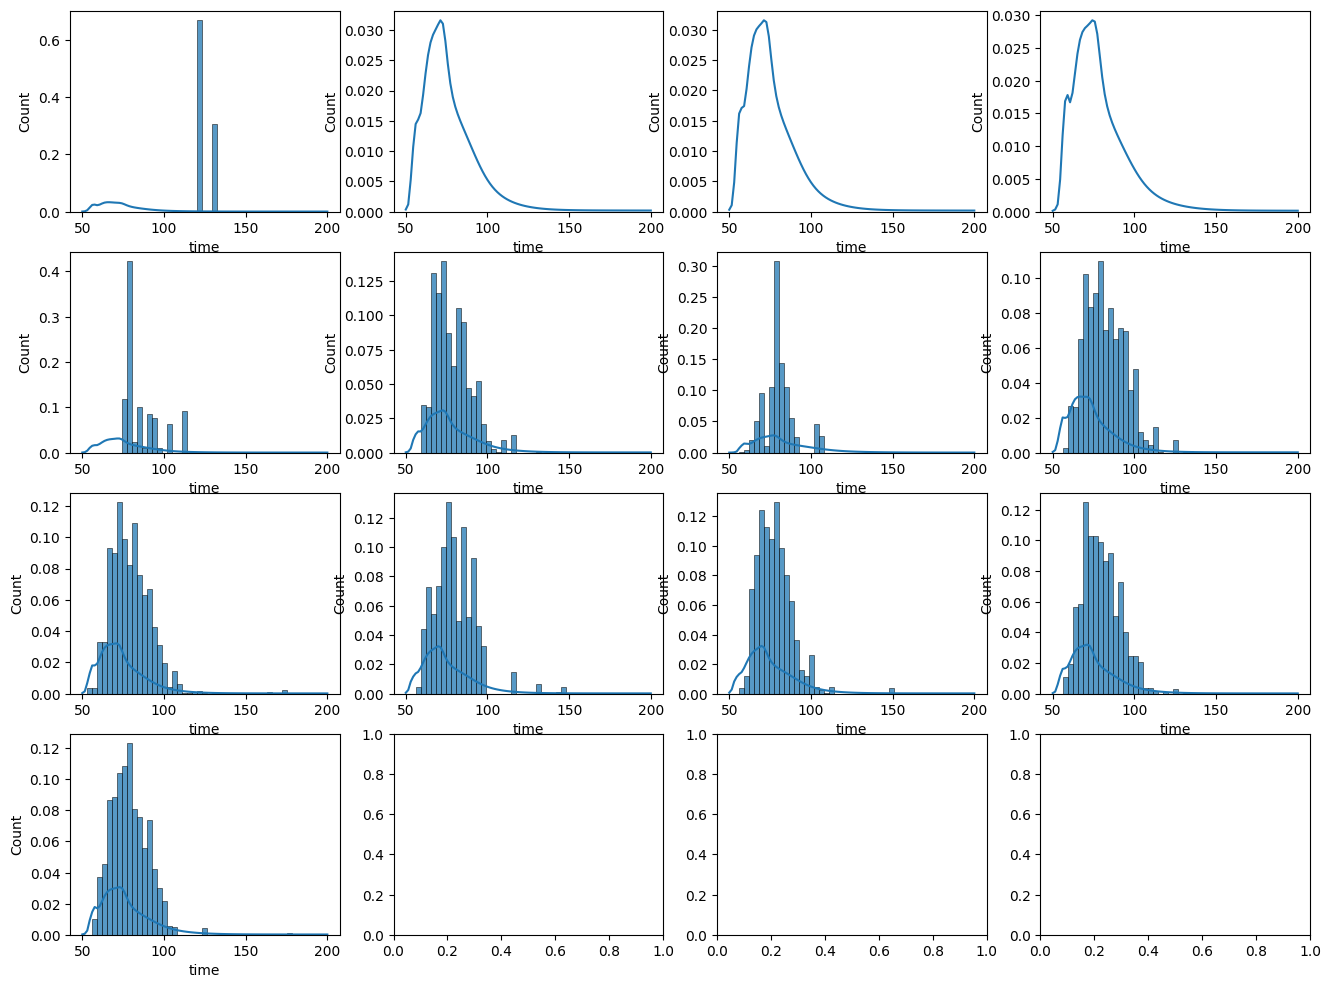

In [69]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]

for i, (grpname, grp) in enumerate(ev[0].groupby("pmt_id")):

    row, col = divmod(i, 4)
    ax = axs[row][col]
    x = grp["time"]
    weights = grp["weight"]
    sns.histplot(x=x, weights=weights, bins=np.linspace(50, 200, 50), ax=ax)

    pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor([int(grpname) - 1]), 16)
    xs = torch.linspace(50, 200, 100)
    labels = torch.empty((xs.shape[0], 16 + len(label_order)), dtype=torch.float64)
    labels_d = ev[1]
    for i, label in enumerate(label_order):
        labels[:, i] = labels_d[label]
    labels[:, len(label_order):] = pmt_encoding
    labels[:, 0] = np.log10(labels[:, 0])
    labels[:, 1] = np.log10(labels[:, 1])

    logpdf, _, _ = pdf(xs[:, np.newaxis].to(device), conditional_input=labels.to(device))
    ax.plot(xs, torch.exp(logpdf).detach().cpu() )
     



In [12]:
ev

(tensor([88.9582, 88.6213, 88.5577,  ..., 91.2363, 89.3823, 91.6626],
        dtype=torch.float64),
 tensor([1.8697e-05, 6.4915e-06, 1.9423e-08,  ..., 7.2944e-06, 2.3484e-05,
         2.6958e-08], dtype=torch.float64),
 tensor([[1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000]],
        dtype=torch.float64))

/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:419: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


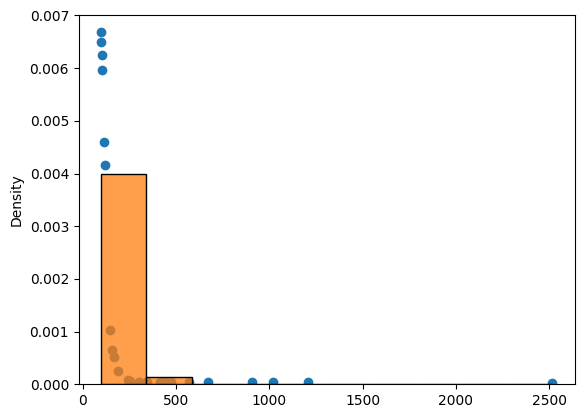

In [10]:
for test_times, test_weights, test_labels in iter(test_dataset):
    if test_times.shape[0] > 40:
        mask = test_labels[:, 17] == 1
        logpdf, _, _ = pdf(test_times[:, np.newaxis].to(device), conditional_input=test_labels.to(device))
        plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
        sns.histplot(x=test_times[mask].detach().cpu(), weights=test_weights[mask].detach().cpu(), stat="density")
        break




In [10]:
test_times, test_labels = next(iter(test_dataset))

logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)


In [13]:
test_times

tensor([176.8423, 178.5658], device='cuda:0', dtype=torch.float64)

<AxesSubplot: >

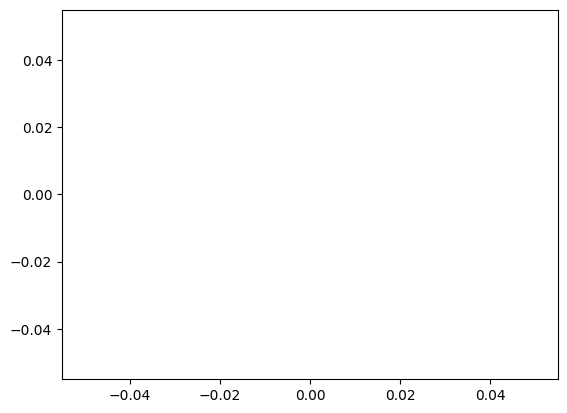

In [12]:
plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
sns.histplot(test_times[mask].detach().cpu(), stat="density")

<AxesSubplot:ylabel='Density'>

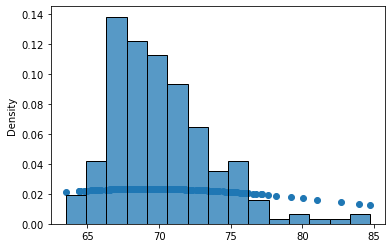

In [29]:
plt.scatter(test_per_pmt[:].detach().cpu(), np.exp(logpdf.detach().cpu()))
sns.histplot(test_per_pmt[:].detach().cpu(), stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [9]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_2"][:, 0])

IndexError: Index (0) out of range for empty dimension